<div style="text-align: center;">

# **Spring 2026 &mdash; CIS 3813<br>Advanced Data Science<br>(Introduction to Machine Learning)**
### Week 4: Multiple Linear Regression & Regularization

</div>

**Date:** 16 February 2026
**Time:** 6:00–9:00 PM  
**Instructor:** Dr. Patrick T. Marsh  
**Course Verse:** "He has shown you, O mortal, what is good. And what does the Lord require of you? To act justly and to love mercy and to walk humbly with your God."  &mdash; *Micah 6:8 (NIV)*

---
## **Week 4 Learning Objectives**

By the end of this lecture, you will be able to:

1. 

---


## **Today's Outline**
- Lecture  
- Break (10-15 Minutes)
- Lab (or Homework)
- Review


---

## **Opening Reflection**


---

## **1.1 Review of Last Week**


---

## **1.2 From Simple to Multiple Linear Regression**

### **1.2.1 Quick Recap: Simple Linear Regression**

In Weeks 1–3, we worked with models that had **one feature** predicting **one target**:

$$\hat{y} = w_0 + w_1 x$$

But real-world problems almost always involve **multiple features**. Think about predicting house prices — you wouldn't use *just* square footage. You'd also want bedrooms, bathrooms, neighborhood, age, etc.

### **1.2.2 Multiple Linear Regression**

With $p$ features, our model becomes:

$$\hat{y} = w_0 + w_1 x_1 + w_2 x_2 + \cdots + w_p x_p$$

Or in **matrix notation** (connecting to last week's linear algebra!):

$$\hat{\mathbf{y}} = \mathbf{X} \mathbf{w}$$

Where:
- $\mathbf{X}$ is our feature matrix (with a column of 1s for the intercept)
- $\mathbf{w}$ is our weight/coefficient vector
- The dot product we learned last week is exactly how predictions are computed!

### **1.2.3 The Objective: Minimize the Cost Function**

We still minimize the **Mean Squared Error (MSE)**, also called the Residual Sum of Squares (RSS):

$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

Let's see this in code.

In [74]:
# Standard imports for tonight's lecture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Plots below may contain warnings. Uncomment these two lines to suppress them.
import warnings
warnings.filterwarnings('ignore')

# Set a consistent style for our plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Scikit-learn imports
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import fetch_california_housing

print("All imports successful! Ready for Week 4.")

All imports successful! Ready for Week 4.


### **1.2.4 Loading a Real Dataset: California Housing**

We'll work with the **California Housing dataset**, a classic ML dataset with 8 features predicting median house value in California districts. (We used this in Week 1.)

In [75]:
# Load the California Housing dataset
housing = fetch_california_housing(as_frame=True)
df = housing.frame

print(f"Dataset shape: {df.shape}")
print(f"\nFeatures: {list(housing.feature_names)}")
print(f"Target: {housing.target_names}")
print(f"\nFirst 5 rows:")
df.head()

Dataset shape: (20640, 9)

Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target: ['MedHouseVal']

First 5 rows:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Let's understand what each feature represents:

In [76]:
print(housing.DESCR[:1500])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

Let's look at some summary statistics. Pay close attention to the scales of the data!

In [77]:
df.describe().round(2)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00
mean,3.87,28.64,5.43,1.10,1425.48,3.07,35.63,-119.57,2.07
std,1.90,12.59,2.47,0.47,1132.46,10.39,2.14,2.00,1.15
min,0.50,1.00,0.85,0.33,3.00,0.69,32.54,-124.35,0.15
25%,2.56,18.00,4.44,1.01,787.00,2.43,33.93,-121.80,1.20
50%,3.53,29.00,5.23,1.05,1166.00,2.82,34.26,-118.49,1.80
75%,4.74,37.00,6.05,1.10,1725.00,3.28,37.71,-118.01,2.65
max,15.00,52.00,141.91,34.07,35682.00,1243.33,41.95,-114.31,5.00


#### **Key Observation: Features Have Very Different Scales!**

Look at the ranges:
- `MedInc` (median income): roughly 0.5 to 15
- `Population`: roughly 3 to 35,682
- `AveRooms`: roughly 0.8 to 141

**This matters for regularization!** We'll come back to this when we discuss why **feature scaling** is essential.

In [78]:
# Prepare features and target
X = df.drop('MedHouseVal', axis=1)
y = df['MedHouseVal']

# Train/test split (80/20) — remember this from Week 1!
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set:     {X_test.shape[0]} samples")

Training set: 16512 samples
Test set:     4128 samples


### **1.2.5 Fitting a Standard Multiple Linear Regression**

In [79]:
# Fit a standard (OLS) linear regression with ALL features
lr = LinearRegression()
lr.fit(X_train, y_train)

# Make predictions
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Evaluate
print("=== Standard Linear Regression ===")
print(f"Train MSE: {mean_squared_error(y_train, y_train_pred):.4f}")
print(f"Test  MSE: {mean_squared_error(y_test, y_test_pred):.4f}")
print(f"Train R²:  {r2_score(y_train, y_train_pred):.4f}")
print(f"Test  R²:  {r2_score(y_test, y_test_pred):.4f}")

=== Standard Linear Regression ===
Train MSE: 0.5179
Test  MSE: 0.5559
Train R²:  0.6126
Test  R²:  0.5758


Let's exame the learned coefficients ...

In [80]:
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print(f"Intercept: {lr.intercept_:.4f}\n")
print("Coefficients (sorted by absolute value):")
print(coef_df.to_string(index=False))

Intercept: -37.0233

Coefficients (sorted by absolute value):
   Feature  Coefficient
 AveBedrms     0.783145
    MedInc     0.448675
 Longitude    -0.433708
  Latitude    -0.419792
  AveRooms    -0.123323
  HouseAge     0.009724
  AveOccup    -0.003526
Population    -0.000002


Let's visualize the coefficients ...

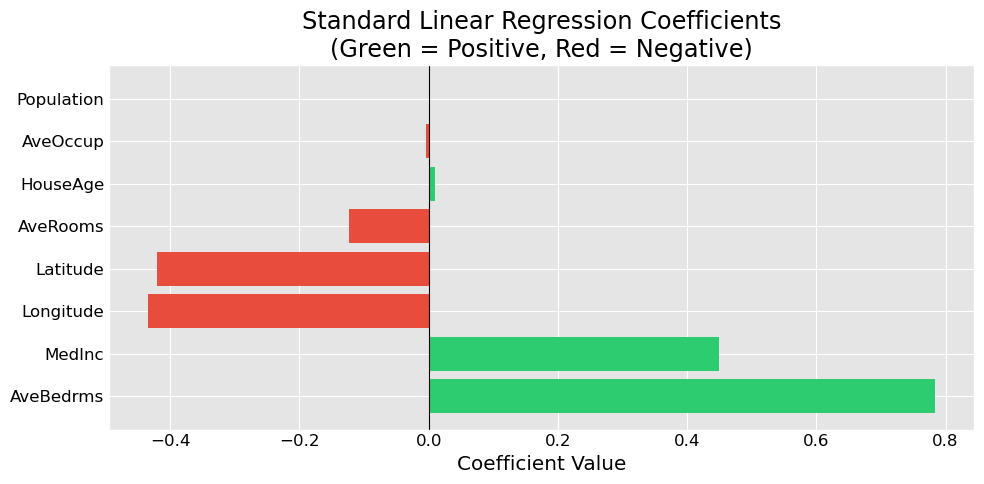

In [81]:
# Visualize the coefficients
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['#2ecc71' if c > 0 else '#e74c3c' for c in coef_df['Coefficient']]
ax.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors)
ax.set_xlabel('Coefficient Value')
ax.set_title('Standard Linear Regression Coefficients\n(Green = Positive, Red = Negative)')
ax.axvline(x=0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

### **1.2.6 The Problem: Can We Trust These Coefficients?**

The coefficients above are **unscaled**. A coefficient of -0.007 for `Population` doesn't mean population is unimportant — it means a 1-unit change in population (1 person) changes the prediction by -0.007. But population ranges from 3 to 35,682!

**Two major problems with standard linear regression:**

1. **Interpretability with different scales:** Coefficients can't be directly compared across features
2. **Overfitting risk:** With many features, the model can memorize training noise

This is where **regularization** comes in!

---
## **1.3 The Idea Behind Regularization**

Imagine a traveler going on a three-day trip to the mountains. He or she isn't sure what the weather will be, so the traveler decides to pack for every possible scenario. He or she packs a parka, a swimsuit, hiking boots, formal shoes, a tuxedo, three umbrellas, and a portable espresso machine.

Now, imagine the traveler gets to the airport and find out the airline has a new policy: **Every pound packed costs $10.** 

Suddenly, the goal isn't just to be 'perfectly prepared'; the goal is to be as prepared as possible for the lowest cost. Travelers have to weigh the 'Accuracy' (having the right outfit) against the 'Penalty' (the baggage weight fee).

Now, there are two different ways to approach this new "cost" problem. 

**Traveler A (Ridge / L2)**  
This traveler decides to bring everything, but in *miniature form*. Instead of a full bottle of shampoo, he or she brings a travel-sized one. Instead of heavy boots, he or she bring ultralight sneakers. He or she brings the tuxedo/formal dress, but it's made of paper-thin fabric.

**Traveler B (Lasso / L1)**  
This travler is ruthless. He or she looks at the tuxedo/formal dress and says, "I'm not paying $10 to carry that." *Toss.* He or she looks at the three umbrellas and keeps only one. *Toss, toss.* By the time the traveler reaches the scale, he or she only has a coat, a pair of boots, and a shirt. 

### **1.3.1 What Is Regularization?**

Regularization adds a **penalty term** to the cost function that discourages the model from making coefficients too large. The intuition: a model with huge coefficients is probably overfitting to noise.

Standard linear regression minimizes:

$$\text{Cost}_{OLS} = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

Regularized regression minimizes:

$$\text{Cost}_{regularized} = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 + \alpha \cdot \text{Penalty}(\mathbf{w})$$

Where $\alpha$ (alpha) controls **how much** we penalize large coefficients.

### **1.3.2 The Two Main Types of Regularization**

| Method | Penalty Term | Effect | Scikit-Learn |
|--------|-------------|--------|-------------|
| **Ridge (L2)** | $\alpha \sum_{j=1}^{p} w_j^2$ | Shrinks coefficients toward zero | `Ridge()` |
| **Lasso (L1)** | $\alpha \sum_{j=1}^{p} \|w_j\|$ | Shrinks AND can set coefficients to exactly zero | `Lasso()` |

### **1.3.3 Back to Our Traveler Analogy**

In our traveler analogy, the original packing strategy is analogous to **ordinary least squares** regression. On paper, the traveler is perfectly prepared for every thing the weather might throw. But this is **overfitting**. The suitcase is exploding, it weighs 100 pounds, and he or she will spend the whole trip digging through junk not needed.

The introduction of a *penalty* for the weight of the bag is known as **regularization**.

The packing equation is changed from making sure the traveler is not unprepared (error) to 

$$ \text{Total Cost} = \text{Unpreparedness } (error) + \text{Baggage Fees } (Penalty) $$

**Traveler A's** approach is analogous to Ridge / L2 Regularization. This travler still has every item, but each one has been shrunk to save weight. Very little (nothing) is left behind, but nothing is "full-strength". This is **Ridge Regression**—it keeps all the variables but minimizes their impact."

**Traveler B's** approach is analogous to Lasso / L1 Regularization. This traveler  looked at the cost of each item and decided that some items simply weren't worth carrying. He or she removed the unimportant items. This traveler has performed **Feature Selection** by looking at the cost and deciding that some items simply aren't worth carrying. He or she essentially **zeroed out** the unimportant items. This is **Lasso Regression**."

### **1.3.4 Intuition: Why L1 Can Zero Out Coefficients but L2 Cannot**

This is one of the most important conceptual differences in ML. Let's visualize it.

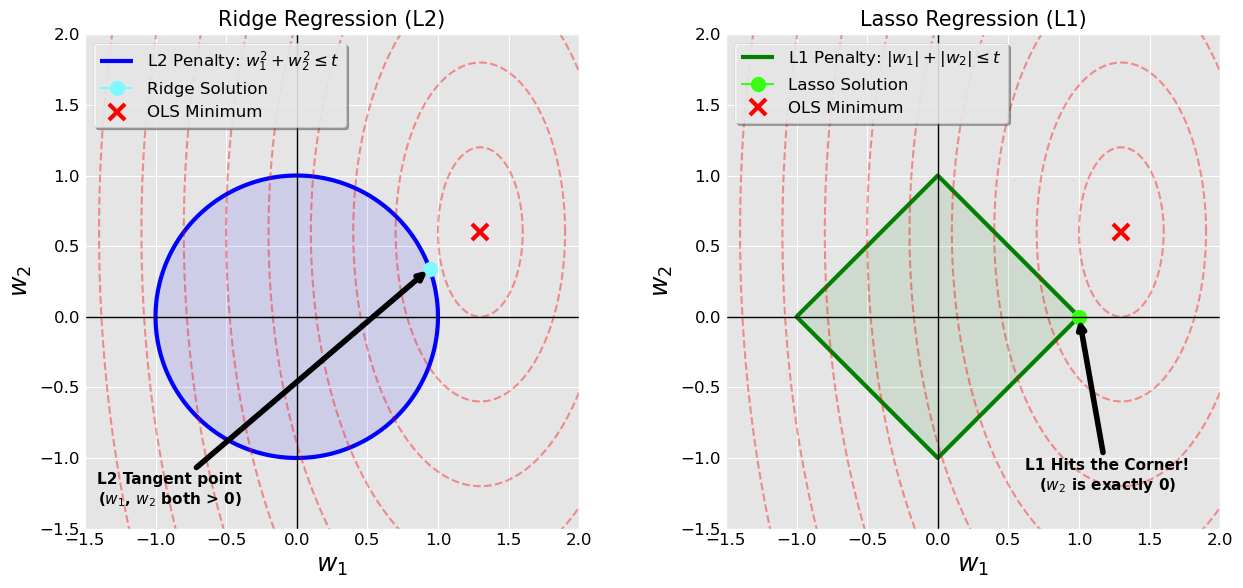

In [82]:
# 1. Setup the figure
fig, axes = plt.subplots(1, 2, figsize=(13, 6))
theta = np.linspace(0, 2 * np.pi, 200)

# Define the "Ideal" OLS solution (center of RSS ellipses)
ols_x, ols_y = 1.3, 0.6

# Define the shared RSS contour parameters
# This represents a steep vertical ellipse
rss_radii = np.arange(0.3, 3.3, 0.3)
x_stretch = 1.0
y_stretch = 2.0

# RSS Contours: Using the vertical ellipse from Lasso subplot
for r in rss_radii:
    ellipse_x = ols_x + r * x_stretch * np.cos(theta)
    ellipse_y = ols_y + r * y_stretch * np.sin(theta)
    ax.plot(ellipse_x, ellipse_y, 'r--', alpha=0.4)

# --- LEFT PLOT: RIDGE (L2) ---
# Penalty: w1^2 + w2^2 <= 1 (A circle)
axes[0].plot(np.cos(theta), np.sin(theta), 'b-', linewidth=3, label='L2 Penalty: $w_1^2 + w_2^2 \leq t$')
axes[0].fill(np.cos(theta), np.sin(theta), color='blue', alpha=0.1)

# Ridge solution: Intersection with the circle (both weights > 0)
# Note: For this specific geometry, the tangent point is roughly at (0.94, 0.34)
ridge_sol_x, ridge_sol_y = 0.94, 0.34
axes[0].plot(ridge_sol_x, ridge_sol_y, marker='o', color='#7DF9FF', markersize=10, label='Ridge Solution')
axes[0].annotate('L2 Tangent point\n($w_1$, $w_2$ both > 0)', xy=(ridge_sol_x, ridge_sol_y),
                 xytext=(-0.9, -1.1), fontsize=11, fontweight='bold', ha='center', va='top',
                 arrowprops=dict(arrowstyle='->', color="black", lw=4))
axes[0].set_title('Ridge Regression (L2)', fontsize=15)


# --- RIGHT PLOT: LASSO (L1) ---
# Penalty: |w1| + |w2| <= 1 (A diamond)
diamond_x, diamond_y = [1, 0, -1, 0, 1], [0, 1, 0, -1, 0]
axes[1].plot(diamond_x, diamond_y, 'g-', linewidth=3, label='L1 Penalty: $|w_1| + |w_2| \leq t$')
axes[1].fill(diamond_x, diamond_y, color='green', alpha=0.1)

# Lasso solution: Hits the corner at (1, 0)
lasso_sol_x, lasso_sol_y = 1.0, 0.0
axes[1].plot(lasso_sol_x, lasso_sol_y, marker='o', color='#39FF14', markersize=10, label='Lasso Solution')
axes[1].annotate('L1 Hits the Corner!\n($w_2$ is exactly 0)', xy=(lasso_sol_x, lasso_sol_y),
                 xytext=(1.2, -1.), fontsize=11, fontweight='bold', ha='center', va='top',
                 arrowprops=dict(arrowstyle='->', color='black', lw=4))
axes[1].set_title('Lasso Regression (L1)', fontsize=15)


# --- COMMON AXES FORMATTING ---
for ax in axes:

    # RSS Contours: Using the vertical ellipse from Lasso subplot
    for r in rss_radii:
        ellipse_x = ols_x + r * x_stretch * np.cos(theta)
        ellipse_y = ols_y + r * y_stretch * np.sin(theta)
        ax.plot(ellipse_x, ellipse_y, 'r--', alpha=0.4)

    # Plot the OLS minimum as a big, bold X at the center of the ellipses
    ax.plot(ols_x, ols_y, 'x', color='#FF0000', markersize=12,
            markeredgewidth=3, label='OLS Minimum')

    ax.set_xlabel('$w_1$', fontsize=18)
    ax.set_ylabel('$w_2$', fontsize=18)
    ax.set_xlim(-1.5, 2.0)
    ax.set_ylim(-1.5, 2.0)
    ax.axhline(y=0, color='black', lw=1); ax.axvline(x=0, color='black', lw=1)
    ax.set_aspect('equal')
    ax.legend()

plt.tight_layout()
plt.show()

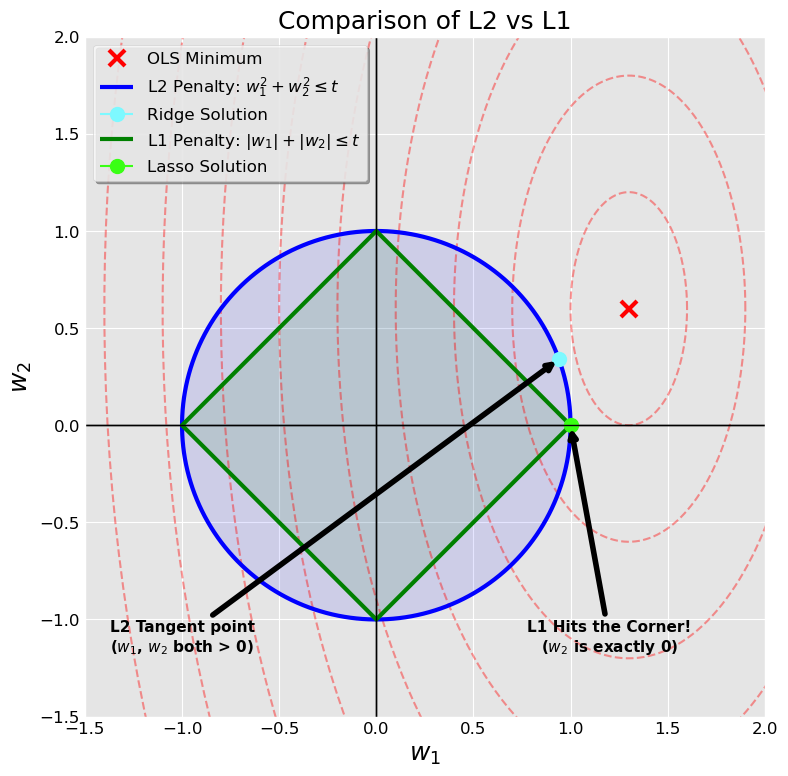

In [83]:
# 1. Setup the figure
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
theta = np.linspace(0, 2 * np.pi, 200)

# Define the "Ideal" OLS solution (center of RSS ellipses)
ols_x, ols_y = 1.3, 0.6

# Plot the OLS minimum as a big, bold X at the center of the ellipses
ax.plot(ols_x, ols_y, 'x', color='#FF0000', markersize=12,
        markeredgewidth=3, label='OLS Minimum')

# Define the shared RSS contour parameters
# This represents a steep vertical ellipse
rss_radii = np.arange(0.3, 3.3, 0.3)
x_stretch = 1.0
y_stretch = 2.0

# RSS Contours: Using the vertical ellipse from Lasso subplot
for r in rss_radii:
    ellipse_x = ols_x + r * x_stretch * np.cos(theta)
    ellipse_y = ols_y + r * y_stretch * np.sin(theta)
    ax.plot(ellipse_x, ellipse_y, 'r--', alpha=0.4)

# --- RIDGE (L2) ---
# Penalty: w1^2 + w2^2 <= 1 (A circle)
ax.plot(np.cos(theta), np.sin(theta), 'b-', linewidth=3, label='L2 Penalty: $w_1^2 + w_2^2 \leq t$')
ax.fill(np.cos(theta), np.sin(theta), color='blue', alpha=0.1)

# Ridge solution: Intersection with the circle (both weights > 0)
# Note: For this specific geometry, the tangent point is roughly at (0.94, 0.34)
ridge_sol_x, ridge_sol_y = 0.94, 0.34
ax.plot(ridge_sol_x, ridge_sol_y, marker='o', color='#7DF9FF', markersize=10, label='Ridge Solution')
ax.annotate('L2 Tangent point\n($w_1$, $w_2$ both > 0)', xy=(ridge_sol_x, ridge_sol_y),
                 xytext=(-1, -1.), fontsize=11, fontweight='bold', ha='center', va='top',
                 arrowprops=dict(arrowstyle='->', color="black", lw=4))

ax.set_title('Ridge Regression (L2)\nSmooth Circular Constraint', fontsize=15)
ax.set_xlim(-1.5, 2.5); ax.set_ylim(-1.5, 2.0)
ax.axhline(y=0, color='black', lw=1); ax.axvline(x=0, color='black', lw=1)
ax.set_aspect('equal'); ax.legend()

# --- LASSO (L1) ---
# Penalty: |w1| + |w2| <= 1 (A diamond)
diamond_x, diamond_y = [1, 0, -1, 0, 1], [0, 1, 0, -1, 0]
ax.plot(diamond_x, diamond_y, 'g-', linewidth=3, label='L1 Penalty: $|w_1| + |w_2| \leq t$')
ax.fill(diamond_x, diamond_y, color='green', alpha=0.1)

# Lasso solution: Hits the corner at (1, 0)
lasso_sol_x, lasso_sol_y = 1.0, 0.0
ax.plot(lasso_sol_x, lasso_sol_y, marker='o', color='#39FF14', markersize=10, label='Lasso Solution')
ax.annotate('L1 Hits the Corner!\n($w_2$ is exactly 0)', xy=(lasso_sol_x, lasso_sol_y),
                 xytext=(1.2, -1.), fontsize=11, fontweight='bold', ha='center', va='top',
                 arrowprops=dict(arrowstyle='->', color='black', lw=4))

ax.set_xlabel('$w_1$', fontsize=18)
ax.set_ylabel('$w_2$', fontsize=18)
ax.set_title('Comparison of L2 vs L1', fontsize=18)
ax.set_xlim(-1.5, 2.0)
ax.set_ylim(-1.5, 2.0)
ax.axhline(y=0, color='black', lw=1); ax.axvline(x=0, color='black', lw=1)
ax.set_aspect('equal')
ax.legend()

plt.tight_layout()
plt.show()

#### **Key Insights**
- The diamond shape of L1 means it has corners on the axes.
- The Residual Sum of the Squares are more likely to first touch a corder (where a coefficient is 0.)
- The circle shape of the L2 has no corners, so solutions are shrunk, but rarely exactly zero.


### **1.3.5 The Role of Alpha ($\alpha$)**

Alpha is the **regularization strength** — it controls the trade-off:

- $\alpha = 0$: No penalty → standard linear regression (OLS)
- $\alpha \to \infty$: Maximum penalty → all coefficients shrink to zero
- "Just right" $\alpha$: Balances fitting the data vs. keeping coefficients small

**Choosing the right alpha is a hyperparameter tuning problem** — we'll cover this systematically in Week 5 with Cross-Validation!

---

## **1.4 Feature Scaling — A CRITICAL Prerequisite**

### **1.4.1 Back to Our Traveler Analogy One More Time**

Feature scaling is a critical prerequisite because regularization is a "fairness" tax based on the size of the coefficient ($w$), and that size is directly dictated by the scale of the feature. In our traveler analogy, imagine if the airline charges based on the **number of items**, not the weight. The travelor would be penalized the same for a heavy bowling ball as for a single sock. This is analogous to using unscaled data with regularization. The penalties are unfair. By scaling data, the traveler is effectively putting everything into "standard boxes." Now, when the airline charges the traveler, it's a fair comparison of how much "space" each item is actually using.

### **1.4.2 Why Scaling Matters for Regularization**

Regularization penalizes the **magnitude** of coefficients. If features are on different scales, the penalty is unfair. Imagine you are predicting house prices using two features:

- **Feature A:** Total Square Footage (Scale: 500 to 5,000)
- **Feature B:** Number of Bedrooms (Scale: 1 to 5)

Because the numbers in Square Footage are much larger, the model only needs a **tiny coefficient** ($w_A$) to have a huge impact on the price. Conversely, it needs a **huge coefficient** ($w_B$) for Bedrooms to make a dent.

| Feature | Scale | Required Weight (w) to move price $10k |
|---------|-------|----------------------------------------|
| Square Feet | 500 – 5000 | $w_A = 2$ |
| Bedrooms | 1 – 5 | $w_B = 2500$ |

The regularization penalty would disproportionately target the large-coefficient features, even if they're not actually more important.

**Solution: Standardize features before regularization!**

This can be done by either the **`StandardScaler`**:

$$x_{scaled} = \frac{x - \mu}{\sigma}$$

After scaling, all features have mean = 0 and standard deviation = 1.

Or the **`MinMaxScaler`**:

$$x_{scaled} = \frac{x - x_{min}}{x_{max} - x_{min}}$$

After scaling, all features are between $[0,1]$.

### **1.4.3 `StandardScaler` Example**

In [85]:
# Scale features using StandardScaler
scaler = StandardScaler()

# IMPORTANT: Fit on training data ONLY, then transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use training mean/std!

# Convert back to DataFrames for readability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print("Scaled training data statistics:")
print(X_train_scaled.describe().round(2).loc[['mean', 'std']])

Scaled training data statistics:
      MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
mean    -0.0      -0.0       0.0       -0.0         0.0       0.0       0.0   
std      1.0       1.0       1.0        1.0         1.0       1.0       1.0   

      Longitude  
mean        0.0  
std         1.0  


#### **REMEMBER:** Always fit the scale on TRAINING data only! Otherwise you leak information from the test set (data leakage).

---

## **1.5 Ridge Regression (L2) in Action**

In [ ]:
# Ridge Regression with different alpha values
alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

print(f"{'Alpha':<10} {'Train MSE':<12} {'Test MSE':<12} {'Test R²':<10} {'# Non-zero Coefs':<18}")
print("-" * 62)

ridge_coefs = {}  # Store coefficients for visualization

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)

    y_train_pred = ridge.predict(X_train_scaled)
    y_test_pred = ridge.predict(X_test_scaled)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    n_nonzero = np.sum(np.abs(ridge.coef_) > 1e-6)

    ridge_coefs[alpha] = ridge.coef_

    print(f"{alpha:<10} {train_mse:<12.4f} {test_mse:<12.4f} {test_r2:<10.4f} {n_nonzero:<18}")

Alpha      Train MSE    Test MSE     Test R²    # Non-zero Coefs  
--------------------------------------------------------------
0.001      0.5179       0.5559       0.5758     8                 
0.01       0.5179       0.5559       0.5758     8                 
0.1        0.5179       0.5559       0.5758     8                 
1.0        0.5179       0.5559       0.5758     8                 
10.0       0.5179       0.5555       0.5761     8                 
100.0      0.5187       0.5533       0.5778     8                 

Notice: Ridge SHRINKS coefficients but never sets them to exactly zero!


#### **NOTICE**: Ridge SHRINKS coefficients but does not set them to exactly zero!

---

## **1.6: Lasso Regression (L1) in Action**

In [92]:
# Lasso Regression with different alpha values
lasso_alphas = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]

print(f"{'Alpha':<10} {'Train MSE':<12} {'Test MSE':<12} {'Test R²':<10} {'# Non-zero Coefs':<18} {'Zeroed Features'}")
print("-" * 90)

lasso_coefs = {}

for alpha in lasso_alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)

    y_train_pred = lasso.predict(X_train_scaled)
    y_test_pred = lasso.predict(X_test_scaled)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    nonzero_mask = np.abs(lasso.coef_) > 1e-6
    n_nonzero = np.sum(nonzero_mask)
    zeroed = [f for f, m in zip(X.columns, ~nonzero_mask) if m]

    lasso_coefs[alpha] = lasso.coef_

    print(f"{alpha:<10} {train_mse:<12.4f} {test_mse:<12.4f} {test_r2:<10.4f} {n_nonzero:<18} {zeroed}")

Alpha      Train MSE    Test MSE     Test R²    # Non-zero Coefs   Zeroed Features
------------------------------------------------------------------------------------------
0.0001     0.5179       0.5557       0.5759     8                  []
0.001      0.5180       0.5545       0.5769     8                  []
0.01       0.5234       0.5483       0.5816     7                  ['Population']
0.1        0.6718       0.6796       0.4814     3                  ['AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Longitude']
0.5        0.9491       0.9400       0.2827     1                  ['HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
1.0        1.3368       1.3107       -0.0002    0                  ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


#### **NOTICE**: Lasso DOES set coefficients to exactly zero — it performs FEATURE SELECTION!

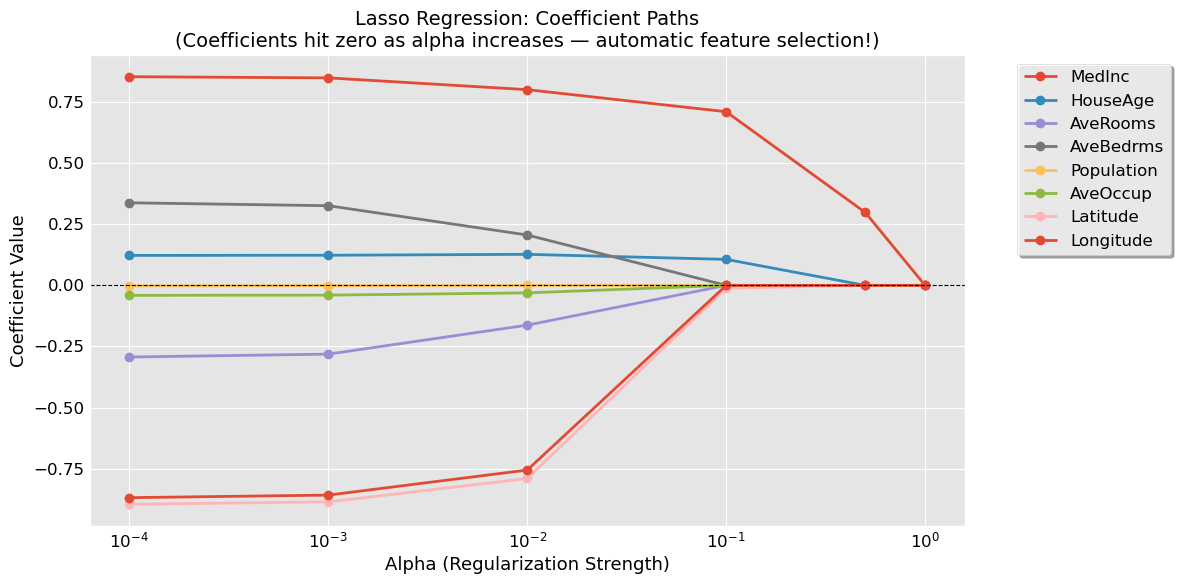

In [89]:
# Visualize how Lasso coefficients change with alpha
fig, ax = plt.subplots(figsize=(12, 6))

for i, feature in enumerate(X.columns):
    coefs = [lasso_coefs[a][i] for a in lasso_alphas]
    ax.plot(lasso_alphas, coefs, 'o-', label=feature, linewidth=2)

ax.set_xscale('log')
ax.set_xlabel('Alpha (Regularization Strength)', fontsize=13)
ax.set_ylabel('Coefficient Value', fontsize=13)
ax.set_title('Lasso Regression: Coefficient Paths\n(Coefficients hit zero as alpha increases — automatic feature selection!)', fontsize=14)
ax.axhline(y=0, color='black', linewidth=0.8, linestyle='--')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [90]:
# Compare OLS, Ridge, and Lasso at a reasonable alpha
alpha_compare = 1.0

# Fit all three models on scaled data
lr_scaled = LinearRegression().fit(X_train_scaled, y_train)
ridge_compare = Ridge(alpha=alpha_compare).fit(X_train_scaled, y_train)
lasso_compare = Lasso(alpha=0.1, max_iter=10000).fit(X_train_scaled, y_train)

# Build comparison table
comparison = pd.DataFrame({
    'Feature': X.columns,
    'OLS': lr_scaled.coef_,
    f'Ridge (α={alpha_compare})': ridge_compare.coef_,
    f'Lasso (α=0.1)': lasso_compare.coef_
})

print("Coefficient Comparison (Scaled Features):")
print("=" * 65)
print(comparison.to_string(index=False, float_format='{:.4f}'.format))

print(f"\nTest R² — OLS:   {r2_score(y_test, lr_scaled.predict(X_test_scaled)):.4f}")
print(f"Test R² — Ridge: {r2_score(y_test, ridge_compare.predict(X_test_scaled)):.4f}")
print(f"Test R² — Lasso: {r2_score(y_test, lasso_compare.predict(X_test_scaled)):.4f}")

Coefficient Comparison (Scaled Features):
   Feature     OLS  Ridge (α=1.0)  Lasso (α=0.1)
    MedInc  0.8544         0.8543         0.7106
  HouseAge  0.1225         0.1226         0.1065
  AveRooms -0.2944        -0.2942        -0.0000
 AveBedrms  0.3393         0.3390         0.0000
Population -0.0023        -0.0023        -0.0000
  AveOccup -0.0408        -0.0408        -0.0000
  Latitude -0.8969        -0.8962        -0.0115
 Longitude -0.8698        -0.8691        -0.0000

Test R² — OLS:   0.5758
Test R² — Ridge: 0.5758
Test R² — Lasso: 0.4814


### **Side-by-Side Comparison of Coefficients**

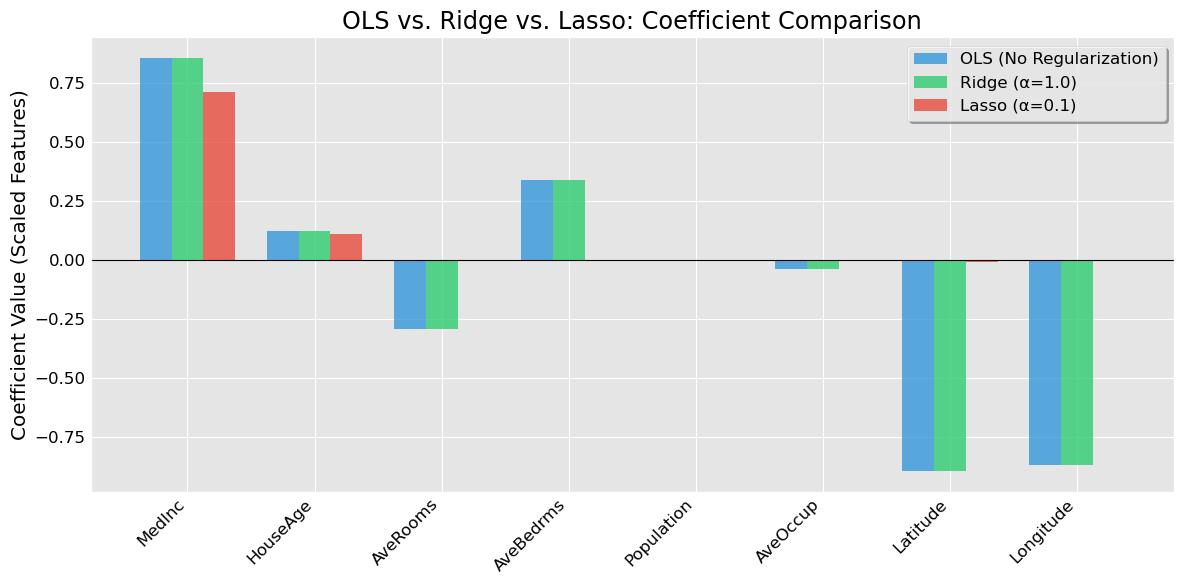

In [91]:
# Visual comparison of coefficients
fig, ax = plt.subplots(figsize=(12, 6))

x_pos = np.arange(len(X.columns))
width = 0.25

ax.bar(x_pos - width, lr_scaled.coef_, width, label='OLS (No Regularization)', color='#3498db', alpha=0.8)
ax.bar(x_pos, ridge_compare.coef_, width, label=f'Ridge (α={alpha_compare})', color='#2ecc71', alpha=0.8)
ax.bar(x_pos + width, lasso_compare.coef_, width, label='Lasso (α=0.1)', color='#e74c3c', alpha=0.8)

ax.set_xticks(x_pos)
ax.set_xticklabels(X.columns, rotation=45, ha='right')
ax.set_ylabel('Coefficient Value (Scaled Features)')
ax.set_title('OLS vs. Ridge vs. Lasso: Coefficient Comparison')
ax.axhline(y=0, color='black', linewidth=0.8)
ax.legend()
plt.tight_layout()
plt.show()

---

## **BREAK (10-15 minutes)**

---

## **2.1 Lab Exercises** (new notebook)

---

## **3.1: Review & Wrap-Up**

### **3.1.1 What We Learned Today**


### **3.1.2 Discussion Questions**


---

## **3.2 Coming Up**
